  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1486k  100 1486k    0     0   211k      0  0:00:07  0:00:07 --:--:--  276k


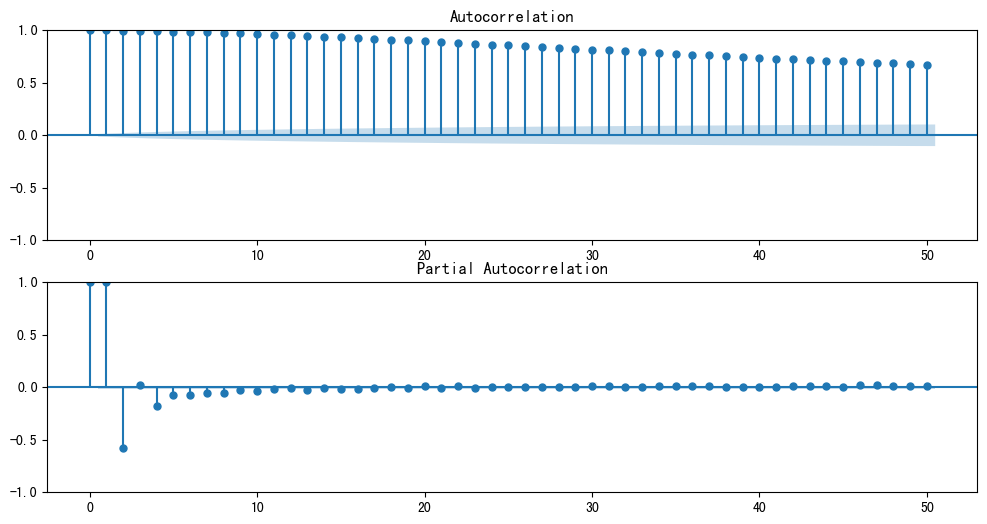

                               SARIMAX Results                                
Dep. Variable:               T (degC)   No. Observations:                26495
Model:                 ARIMA(1, 1, 2)   Log Likelihood                -959.126
Date:                Tue, 14 May 2024   AIC                           1926.252
Time:                        02:06:08   BIC                           1958.990
Sample:                    07-01-2021   HQIC                          1936.819
                         - 12-31-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9212      0.004    235.816      0.000       0.914       0.929
ma.L1         -0.3475      0.005    -68.849      0.000      -0.357      -0.338
ma.L2         -0.3294      0.005    -71.255      0.0

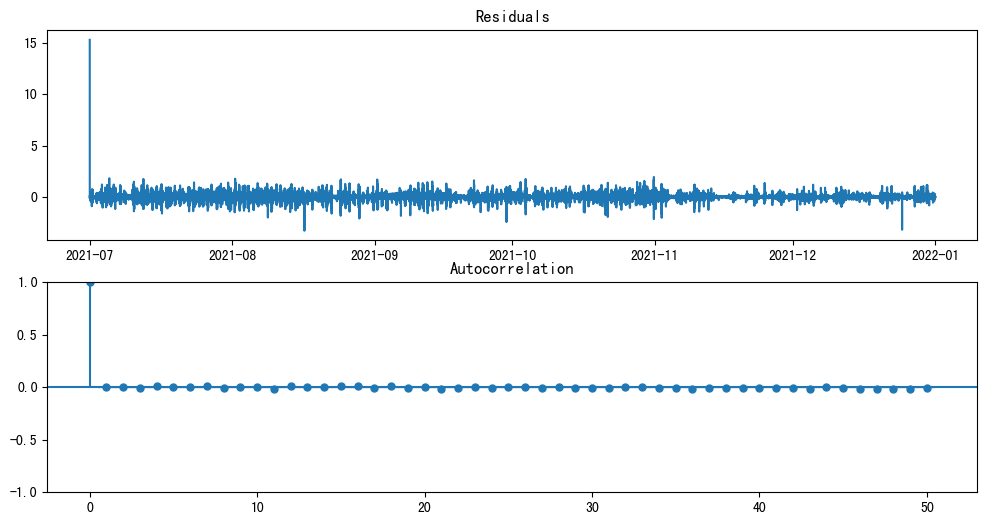

ADF Statistic: -26.642738790433363
p-value: 0.0
Critical Values 1%: -3.430597303265833
Critical Values 5%: -2.861649300819177
Critical Values 10%: -2.566828177584438
      lb_stat  lb_pvalue
1    0.058946   0.808170
2    0.062176   0.969390
3    2.354536   0.502154
4    5.033534   0.283874
5    5.072241   0.407128
6    5.150345   0.524680
7    8.495868   0.290903
8    9.090123   0.334750
9    9.310324   0.409136
10  10.166195   0.426035
2022-01-01 00:00:00    13.550830
2022-01-01 00:10:00    13.548867
2022-01-01 00:20:00    13.547059
2022-01-01 00:30:00    13.545393
2022-01-01 00:40:00    13.543858
Freq: 10T, Name: predicted_mean, dtype: float64


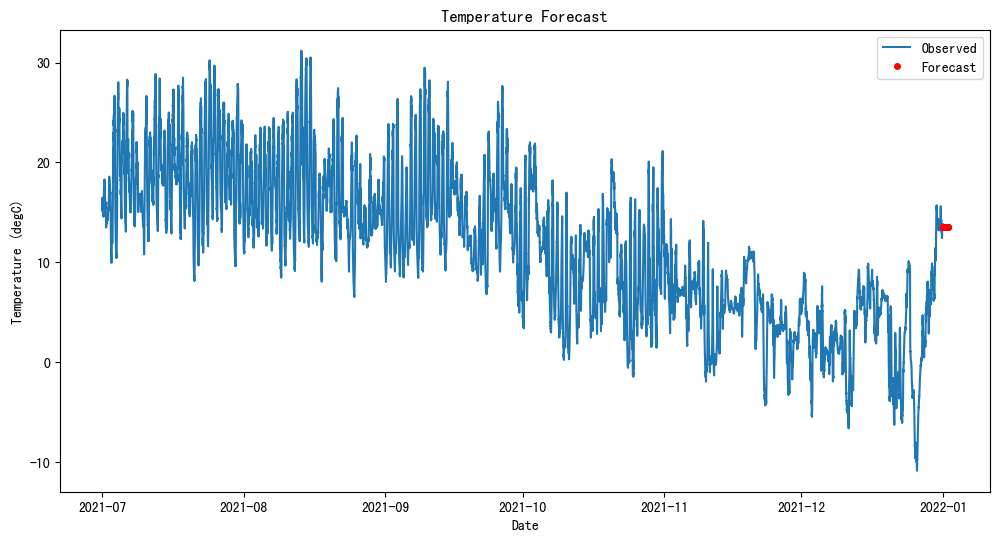

Date Time
2022-01-01    13.52
Freq: 10T, Name: T (degC), dtype: float64
Mean Squared Error (MSE): 0.0009504642081317397


In [3]:
import zipfile
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.stats.diagnostic import acorr_ljungbox

# 下载并解压数据集
!curl -O https://www.bgc-jena.mpg.de/wetter/mpi_saale_2021b.zip

with zipfile.ZipFile("mpi_saale_2021b.zip", 'r') as zip_ref:
    zip_ref.extractall()

# 读取数据并进行初步检查
csv_path = "mpi_saale_2021b.csv"
data_frame = pd.read_csv(csv_path)
time = pd.to_datetime(data_frame['Date Time'], dayfirst=True)
temperature = data_frame['T (degC)']
temperature.index = time
temperature = temperature.asfreq('10T')  # 设置时间频率为10分钟

# 选择训练数据（7月1日至12月31日）
train_start = '2021-07-01'
train_end = '2021-12-31'
train_data = temperature[train_start:train_end]

# 绘制ACF和PACF图以选择模型参数
plt.figure(figsize=(12, 6))
plt.subplot(211)
plot_acf(train_data.dropna(), lags=50, ax=plt.gca())
plt.subplot(212)
plot_pacf(train_data.dropna(), lags=50, ax=plt.gca())
plt.show()

# 构建和拟合ARIMA模型
model = ARIMA(train_data, order=(1, 1, 2))
model_fit = model.fit()
print(model_fit.summary())

# 残差诊断
residuals = model_fit.resid

# 绘制残差图
plt.figure(figsize=(12, 6))
plt.subplot(211)
plt.plot(residuals)
plt.title('Residuals')
plt.subplot(212)
plot_acf(residuals, lags=50, ax=plt.gca())
plt.show()

# Dicky-Fuller Test
adf_test = adfuller(residuals)
print(f'ADF Statistic: {adf_test[0]}')
print(f'p-value: {adf_test[1]}')
for key, value in adf_test[4].items():
    print(f'Critical Values {key}: {value}')

# 白噪声诊断（Ljung-Box检验）
ljung_box_test = acorr_ljungbox(residuals, lags=10, return_df=True)
print(ljung_box_test)

# 预测2022年1月1日当天的温度数据
forecast_steps = 24 * 6  # 1天的预测步数（每10分钟一个数据）
forecast = model_fit.forecast(steps=forecast_steps)

# 创建日期范围
forecast_index = pd.date_range(start='2022-01-01', periods=forecast_steps, freq='10T')

# 创建Series来存储预测数据
forecast_series = pd.Series(forecast, index=forecast_index)

# 打印前几行预测数据
print(forecast_series.head())

# 绘制预测数据图表
plt.figure(figsize=(12, 6))
plt.plot(temperature['2021-07-01':], label='Observed')
plt.plot(forecast_series, label='Forecast', color='red', linestyle='None', marker='o', markersize=4)
plt.title('Temperature Forecast')
plt.xlabel('Date')
plt.ylabel('Temperature (degC)')
plt.legend()
plt.show()

# 检查实际数据是否完整
actual_data = temperature['2022-01-01']
print(actual_data.head())

# 过滤掉 NaN 值，确保长度一致
actual_data = actual_data.dropna()
forecast_series = forecast_series.loc[actual_data.index]

# 计算MSE
mse = mean_squared_error(actual_data, forecast_series)
print(f'Mean Squared Error (MSE): {mse}')
